In [22]:
import rioxarray
import numpy as np
import pandas as pd
from datascience import *   
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib
from xgboost import plot_importance

In [139]:
HEIGHT = 90
WIDTH = 250
# all_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y19 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m4_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
m10_y20 = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
cordinates = {}
tmp_name = ['AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
file_name = [['Precipitation','AWS']]
opt_file_name = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']
for i in range(1,len(tmp_name)):
    file_name.append(['ERA5',tmp_name[i]])
# file_name

Hàm lấy các tọa độ có dữ liệu AWS

In [3]:
def get_AWS_cordinates(hour_list, day_list, month_list, year_list, cordinates):
    for year in year_list:
        for month in month_list:
            for day in day_list:
                for hour in hour_list:
                    file_path = f'DATA_SV/Precipitation/AWS/{year}/{month:02}/{day:02}/AWS_{year}{month:02}{day:02}{hour:02}0000.tif'
                    path = Path(file_path)
                    if not path.is_file():
                        continue
                    dataset = rioxarray.open_rasterio(file_path)
                    data = dataset[0].values
                    for i in range(HEIGHT):
                        for j in range(WIDTH):
                            if data[i][j] != -np.inf:
                                cordinates[(i,j)] = True
                                # print(i,j)
    cordinates = sorted(cordinates)

Hàm đọc dữ liệu

In [4]:

def read(hour, day, month, year, file, cordinates, all_data):
    data = []
    for i in range(len(file)):
        name1 = file[i][0]
        name2 = file[i][1]
        file_path = f'DATA_SV/{name1}/{name2}/{year}/{month:02}/{day:02}/{name2}_{year}{month:02}{day:02}{hour:02}0000.tif'
        # print(file_path)
        path = Path(file_path)
        if not path.is_file():
            return
        # print(file_path)
        dataset = rioxarray.open_rasterio(file_path)
        data.append(dataset[0].values)
        
    # print(len(data))
    if(data != []): 
        for pos in cordinates:
            i = pos[0]
            j = pos[1]
            check = True
            tmp = [datetime(year,month,day,hour)]
            for z in range(len(data)):
                if(data[z][i][j] == -np.inf or data[z][i][j] == np.inf or data[z][i][j] == np.nan):
                    check = False
                    break
                tmp.append(data[z][i][j])
            if check:
                all_data[i][j].append(tmp)
                # print(all_data[i][j])
    # print(all_data)
            

Đọc dự liệu trong khoảng thời gian định sẵn tại đây. dữ liệu all_data[i][j][z] là tại vị trí i, j có tập giá trị tương ứng tại cùng thời điểm

In [6]:

for i in range(HEIGHT):
    for j in range(WIDTH):
        m4_y19[i][j] = []
        m10_y19[i][j] = []
        m4_y20[i][j] = []
        m10_y20[i][j] = []
cordinates.clear
# hour = [0]
hour = [i for i in range(24)]
# day = [1]
# day = [i for i in range(27,28)]
day = [i for i in range(1,32)]
# month = [4]
month = [4,10]
# year = [2019] 
year = [2019,2020]
get_AWS_cordinates(hour, day, month, year, cordinates)
cordinates_list = list(cordinates)
for k in day:
    for l in hour:
        read(l, k, month[0], year[0], file_name, cordinates_list, m4_y19)
        read(l, k, month[1], year[0], file_name, cordinates_list, m10_y19)
        read(l, k, month[0], year[1], file_name, cordinates_list, m4_y20)
        read(l, k, month[1], year[1], file_name, cordinates_list, m10_y20)
# print(len(cordinates_list))

In [100]:
all_data = []
for (i,j) in cordinates_list:
    for data in m4_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y19[i][j]:
        all_data.append([i,j] + data)
    for data in m4_y20[i][j]:
        all_data.append([i,j] + data)
    for data in m10_y20[i][j]:
        all_data.append([i,j] + data)
print((all_data[0]))
    

[0, 114, datetime.datetime(2019, 4, 1, 0, 0), 0.0, 446.125, 38.875008, -641.11328, -1.3912562e-05, 0.58824843, 37.360176, -1.5529804e-05, 33.599831, 39.494701, 94.882187, -127783.0, 0.019672839, -11962.0, 0.72320557, 49.239563, 48.219376, 25.793488, -3.6066742, 4.5234528, 7.3280945]


Tải dữ liệu ra csv

In [135]:
print(len(all_data[0]))
df = pd.DataFrame(all_data, columns=['row','column','time'] + tmp_name)
df.to_csv('data.csv', index=False)

24


Nếu đã có file data.csv thì đọc từ đây

In [143]:
data_csv = pd.read_csv('data.csv')
column_data = data_csv[['row','column','time']+opt_file_name]
all_data = column_data.values.tolist()
# all_data = np.array(all_data)
for i in range(len(all_data)):    
    all_data[i][2] = datetime.strptime(all_data[i][2], '%Y-%m-%d %H:%M:%S')

Xây dựng bộ dữ liệu X,y để cho vào mô hình. 

In [145]:
def create_data(all_data, X, y, num_pre, num_data):
    for z in range(num_pre,int(len(all_data))-num_data+1):
        data = all_data[z:z+num_data]  
        pre_data = all_data[z-num_pre:z]
        check = True
        for k in range(z-num_pre,z+num_data):
            # print(all_data[i][j][k])
            if (all_data[k][2] - all_data[k-1][2]).total_seconds() == 3600:
                check = False
                break
        if check:
            continue
        
        # print(len(pre_data),len(data))
        pre_data = np.array(pre_data)
        data = np.array(data)
        
        # print(pre_data.shape,data.shape)
        
        pre_data = pre_data[:,3:].reshape(-1)
        data = data[:,3].reshape(-1)

        
        X.append(pre_data)
        y.append(data)
        # print(pre_data[2:],data[1])

In [146]:
X_train = []
y_train = []
X_test = []
y_test = []

X = []
y = []
create_data(all_data, X, y, 3, 6)
# create_data(m4_y19, cordinates_list, X, y,  3, 6)
# create_data(m10_y19, cordinates_list, X, y, 3, 6)
# create_data(m4_y20, cordinates_list, X, y, 3, 6)
# create_data(m10_y20, cordinates_list, X, y, 3, 6)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create_data(m4_y19, cordinates_list, X_train, y_train, 6,  3)
# create_data(m10_y19, cordinates_list, X_train, y_train, 6, 3)
# create_data(m4_y20, cordinates_list, X_train, y_train, 6, 3)
# create_data(m10_y20, cordinates_list, X_test, y_test, 6, 3)
# print(len(X_train),len(y_train))

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(525526, 30)
(525526, 6)
(131382, 30)
(131382, 6)


In [10]:
param_dist = {
    'n_estimators': randint(50, 70),
    'max_depth': [None],
    # 'min_samples_split': randint(2, 3),
    # 'min_samples_leaf': randint(1, 3)
}

# print(param_dist)
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=20, cv=5)

In [30]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

param_dist = {
    'learning_rate': np.linspace(0.001, 0.1, 20),
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
}

# Tạo đối tượng RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 100,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

# print(random_search)

In [147]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

AWS 3445.0
V850 3003.0
EWSS 2671.0
CAPE 2564.0
ISOR 2196.0
IE 2154.0
KX 2061.0
CIN 2022.0
PEV 1971.0
R850 1957.0
R250 1736.0
R500 881.0
TCLW 820.0
TCWV 770.0
SLOR 748.0
SSHF 729.0
TCW 713.0
U250 702.0
SLHF 661.0
U850 557.0
V250 528.0
Mean Squared Error: 3.2595713138580322


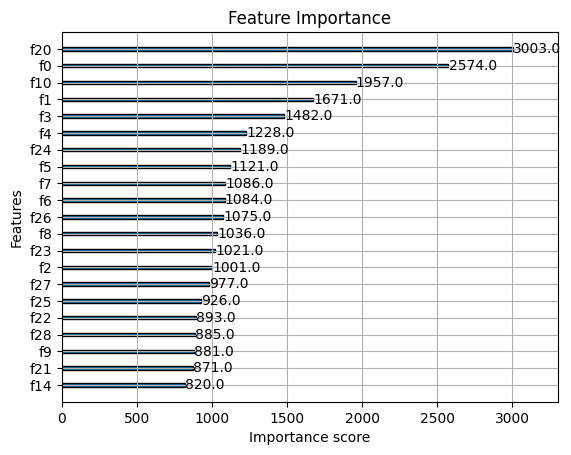

In [ ]:
# plot_importance(xgb_model, importance_type='weight', max_num_features=21, title='Feature Importance')
# importance = xgb_model.get_booster().get_score(importance_type='weight')
# new_importance = {}
# for i,(key, value) in enumerate(importance.items()):
#     feature_name = f'{tmp_name[int(key[1:]) % 21]}'
#     new_importance[feature_name] = new_importance.get(feature_name, 0) + value
# importance = new_importance
# sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)
# for (key, value) in sorted_importance:
#     print(key, value)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# for i in range(y_pred.shape[0]):
#     print('pred',y_pred[i])
#     print('real',y_test[i])

Lưu mô hình

In [15]:
joblib.dump(random_search, 'model.pkl')

['model.pkl']

In [16]:
load_model = joblib.load('model.pkl')
y_pred = load_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.2730963230133057
